In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, integrate
from scipy.integrate import ode, solve_ivp
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

# Exploração dos dados

In [2]:
main_data = pd.read_csv('../data/min_saude_sp.csv')

In [289]:
datas = main_data['data'].to_list()

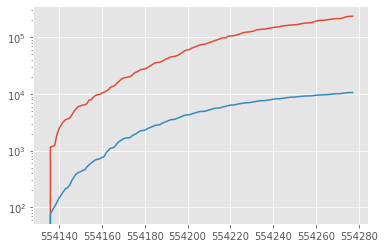

In [291]:
plt.semilogy(main_data[['casosAcumulado','obitosAcumulado']])
plt.grid(True)

In [292]:
#vizualizando casos, mortes e suas médias móveis
casos = main_data['casosNovos'].to_list()
mortes = main_data['obitosNovos'].to_list()

In [299]:
media_casos = main_data.casosNovos.rolling(window=7).mean()
media_mortes = main_data.obitosNovos.rolling(window=7).mean()

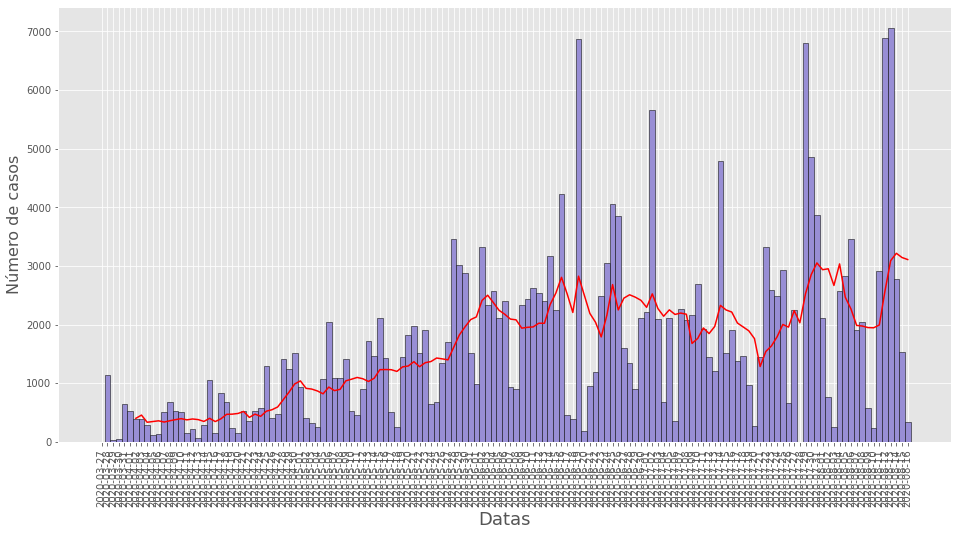

In [306]:
figure = plt.figure(figsize=(16, 8))
bars = plt.bar(datas, casos, width=1.0, align='center', edgecolor='black', color='C2')
plt.plot(datas, media_casos, color='red')
plt.xticks(rotation=90)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Número de casos', fontsize=16)
plt.show()

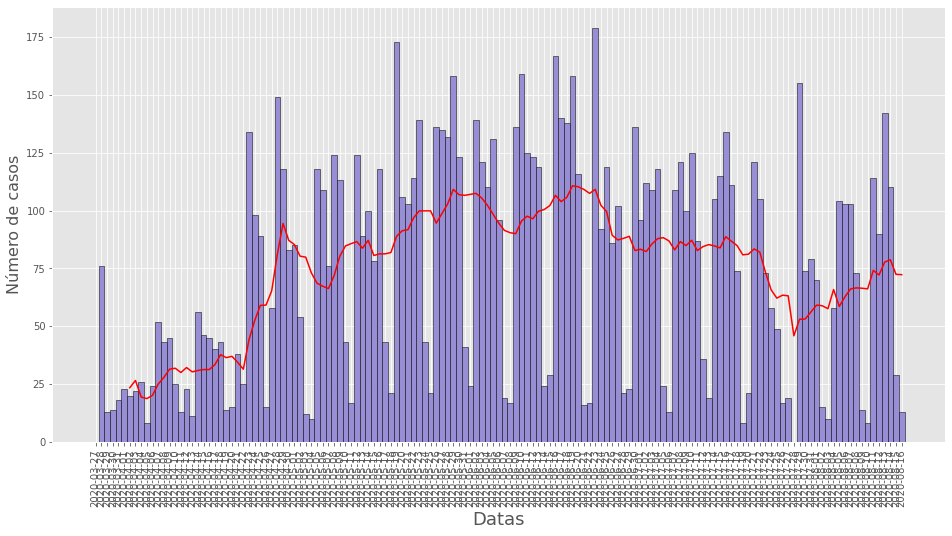

In [310]:
figure = plt.figure(figsize=(16, 8))
bars = plt.bar(datas, mortes, width=1.0, align='center', edgecolor='black', color='C2')
plt.plot(datas, media_mortes, color='red')
plt.xticks(rotation=90)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Número de casos', fontsize=16)
plt.show()

143
[    0    76    89   103   121   144   164   186   212   220   244   296
   339   384   409   422   445   456   512   558   603   643   686   700
   715   753   778   912  1010  1099  1114  1172  1321  1439  1522  1607
  1661  1673  1683  1801  1910  1986  2110  2223  2266  2283  2407  2496
  2596  2674  2792  2835  2856  3029  3135  3238  3352  3491  3534  3555
  3691  3826  3958  4116  4239  4280  4304  4443  4564  4674  4805  4901
  4920  4937  5073  5232  5357  5480  5599  5623  5652  5819  5959  6097
  6255  6371  6387  6404  6583  6675  6794  6880  6982  7003  7026  7162
  7258  7370  7479  7597  7621  7634  7743  7864  7964  8089  8176  8212
  8231  8336  8451  8585  8696  8770  8778  8799  8920  9025  9098  9156
  9205  9222  9241  9241  9396  9470  9549  9619  9634  9644  9702  9806
  9909 10012 10085 10099 10107 10221 10311 10453 10563 10592 10605]


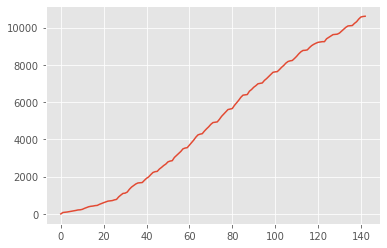

In [318]:
casos_acumulados = main_data['casosAcumulado'].values[::1]
mortes_acumuladas = main_data['obitosAcumulado'].values[::1]

print(len(mortes_acumuladas))
print(mortes_acumuladas)
plt.plot(mortes_acumuladas)

# Definição do modelo

In [319]:
def seird_ode(y, t, beta, N):
    
    σ = 1/5.2  #período de incubação
    α = 0.2    #taxa de hospitalização
    ξ = 0.3    #mortalidade entre hospitalizados
    λ = 1/7    #tempo no hospital
    γ = 1/3.2  #período infectante
    
    S, E, I, R, D = y
    
    # ODEs
    
    dS = -(beta(t)*I*S)/N 
    dE = (beta(t)*I*S)/N - σ*E
    dI = σ*E - (1-α)*γ*I - α*λ*I
    dR = (1-α)*γ*I  + α*(1-ξ)*λ*I
    dD = α*ξ*λ*I
    
    return dS, dE, dI, dR, dD

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, R_0_start, k, x0, R_0_end):
    
    γ = 1/3.2
    
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * γ
    
    N = 12e6
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = integrate.odeint(seird_ode, y0, t, args=(beta, 12e6))
    S, E, I, R, D = ret.T
    R_0_over_time = [beta(i)/γ for i in range(len(t))]
    
    return t, S, E, I, R, D, R_0_over_time

In [320]:
sir_sol = Model(days=40, R_0_start=2.5, k=1.0, x0=60, R_0_end=1.0)
sir_out = pd.DataFrame({"t":sir_sol[0],
                        "S":sir_sol[1],
                        "E":sir_sol[2],
                        "I":sir_sol[3], 
                        "R":sir_sol[4],
                        "D":sir_sol[5]
                       })

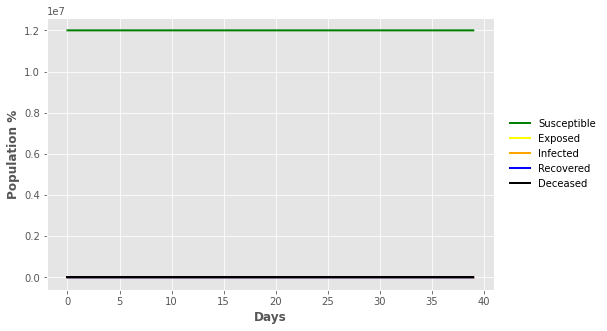

In [321]:
sir_out.columns=["t", "Susceptible", "Exposed", "Infected", "Recovered", "Deceased"]

plt.style.use("ggplot")
plt.figure(figsize=(8,5))
sline = plt.plot("t","Susceptible","",data=sir_out,color="green",linewidth=2)
eline = plt.plot("t","Exposed","",data=sir_out,color="yellow",linewidth=2)
iline = plt.plot("t","Infected","",data=sir_out,color="orange",linewidth=2)
rline = plt.plot("t","Recovered","",data=sir_out,color="blue",linewidth=2)
dline = plt.plot("t","Deceased","",data=sir_out,color="black",linewidth=2)
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Population %",fontweight="bold")
legend = plt.legend(title="",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

# Ajuste dos parâmetros

In [367]:
ndays = 143

params_init_min_max = {"R_0_start": (4.0, 3.0, 6.0),
                       "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120),
                       "R_0_end": (0.9, 0.3, 2.0)}


x_data = np.linspace(0, ndays - 1, ndays, dtype=int)
y_data = mortes_acumuladas

In [368]:
def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(ndays, R_0_start, k, x0, R_0_end)
    return ret[5][x]

In [369]:
mod = lmfit.Model(fitter)

In [370]:
for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

In [371]:
params = mod.make_params()
fit_method = "leastsq"

In [372]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

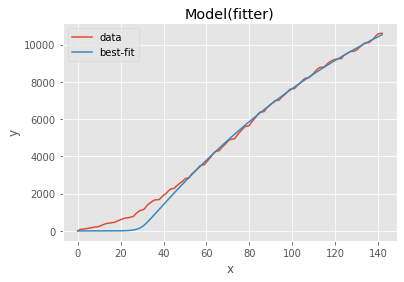

In [373]:
result.plot_fit(datafmt="-");

In [374]:
result.best_values

{'R_0_start': 5.999999999999999,
 'k': 4.999999999999953,
 'x0': 29.742511245967684,
 'R_0_end': 0.8472926137715557}

In [375]:
sir_sol = Model(days=170, **result.best_values)

In [376]:
sir_out = pd.DataFrame({"t":sir_sol[0],
                        "S":sir_sol[1],
                        "E":sir_sol[2],
                        "I":sir_sol[3], 
                        "R":sir_sol[4],
                        "D":sir_sol[5]
                       })

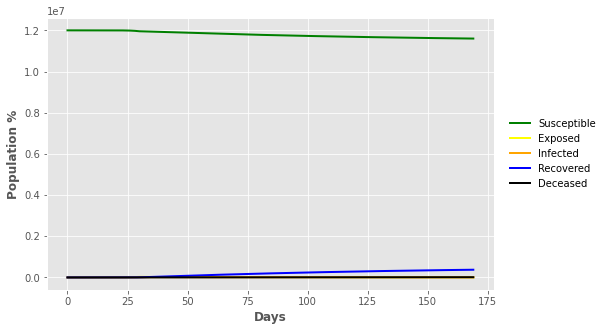

In [377]:
sir_out.columns=["t", "Susceptible", "Exposed", "Infected", "Recovered", "Deceased"]

plt.style.use("ggplot")
plt.figure(figsize=(8,5))
sline = plt.plot("t","Susceptible","",data=sir_out,color="green",linewidth=2)
eline = plt.plot("t","Exposed","",data=sir_out,color="yellow",linewidth=2)
iline = plt.plot("t","Infected","",data=sir_out,color="orange",linewidth=2)
rline = plt.plot("t","Recovered","",data=sir_out,color="blue",linewidth=2)
dline = plt.plot("t","Deceased","",data=sir_out,color="black",linewidth=2)
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Population %",fontweight="bold")
legend = plt.legend(title="",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

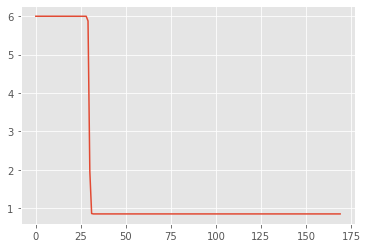

In [378]:
#R0 ao longo do tempo
plt.plot(sir_sol[6])

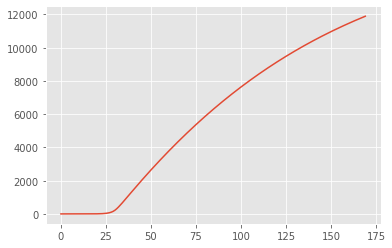

In [381]:
#obitos
plt.plot(sir_sol[5])